In [10]:
import numpy as np
from functools import partial
import pandas as pd
#import matplotlib as mpl
#mpl.rcParams['legend.numpoints'] = 1
import matplotlib.pyplot as plt
%matplotlib inline 

def get_heatRes_FWHM(sig0, aH, E_keV):
    """return the heat FWHM at energy E_keV.  sig0, E_keV assumed to be in units of keV."""
    
    # see eqn (5) in 2004 NIMA Edelweiss paper
    sigH = np.sqrt(sig0**2 + (aH*E_keV)**2)
    
    # multiply by 2.355 to get FWHM
    return sigH*2.355

def get_heatRes_FWHM_func(FWHM0, FWHM122):
    """returns a FWHM resolution function given the FWHM values at 0 keV and 122 keV"""
    
    # convert from FWHM to sigma
    sig0 = FWHM0/2.355
    sig122 = FWHM122/2.355
    
    # calculate aH, which is unitless
    aH = np.sqrt((sig122**2 - sig0**2)/122**2)
    #print (aH)
    
    # create function
    return partial(get_heatRes_FWHM, sig0, aH)
    

In [23]:
heatRes_GGAl10 = get_heatRes_FWHM_func(0.4, 3.5)
heatRes_GGAl10_guard = get_heatRes_FWHM_func(0.655, 4.0)

In [5]:
heatRes_GGAl10(50)

1.4801027369064297

In [21]:
heatRes_data = pd.read_csv("resolution_GeAl10_dataPoints_correctedEnergies.txt", skiprows=1)
print (heatRes_data.head(10))

   Energy    FWHM   error
0  122.10  3.9992  0.4938
1   46.52  1.8558  0.2918
2   10.37  0.6831  0.0757
3    0.00  0.6551  0.0814


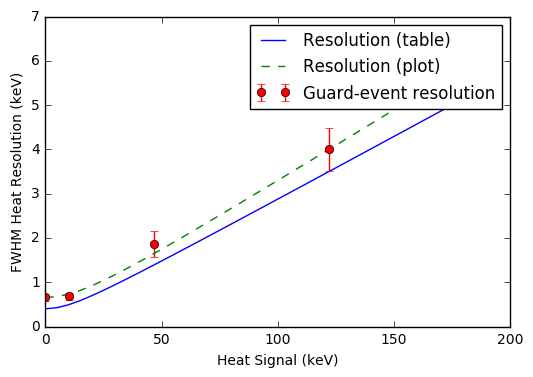

In [34]:
# plot the heat resolution, reproduce fig 2d from 2004 NIMA Edelweiss paper
E_vec = np.arange(0,200,5)
table, = plt.plot(E_vec, heatRes_GGAl10(E_vec), label='Resolution (table)')
plot, = plt.plot(E_vec, heatRes_GGAl10_guard(E_vec), linestyle='--', label='Resolution (plot)')
data = plt.errorbar(heatRes_data.Energy, heatRes_data.FWHM,yerr=heatRes_data.error,fmt='o', label='Guard-event resolution')
plt.xlabel("Heat Signal (keV)")
plt.ylabel("FWHM Heat Resolution (keV)")
plt.legend(handles=[table, plot, data])